In [1]:
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix, csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import eigh

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['helvetica'],'size': 16})
rc('text', usetex=True)

import jax
from jax import jit
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev, vjp
from jax.scipy.linalg import expm
from jax.lax import fori_loop
jax.config.update("jax_enable_x64", True)

## Molecule setup

In [2]:
def get_toy_example(J,g):
    JAB = g*jnp.array([[1,1]])
    JB = J*jnp.array([[0,1],[1,0]])
    return JAB, JB

def encode_params(JAB, JBB, Delta):
    nA = JAB.shape[0]
    nB = JAB.shape[1]
    assert JBB.shape[0]==nB
    assert JBB.shape[1]==nB
    assert len(Delta) == nB

    dim = int(nA*nB+nB*(nB+1)/2)
    theta = np.zeros([dim])
    JAB = np.reshape(JAB, [nA, nB])
    theta[:nA*nB] = JAB
    counter = 0
    for i in range(nB):
        for j in range(i+1,nB):
            theta[nA*nB+counter] = JBB[i,j]
            counter += 1
    theta[nA*nB+counter:] = Delta
    return theta

def get_haar_random_state(dimH, m):
    np.random.seed(m)
    psi0 = np.random.normal(0,1,dimH) + 1j * np.random.normal(0,1,dimH)
    return psi0/np.sqrt(np.dot(psi0.conj(), psi0))


# Jaxed Autodiffing

### Helper functions

In [4]:
# Helper Functions

def int2array(states, L):
    # states is (N, )
    N = states.shape[0]
    toret = jnp.zeros((N, L)).astype('int')
    for i in range(L):
        toret = toret.at[:,-i-1].set(states % 2)
        states = states // 2
    return toret

def array2int(states):
    # states is (N, L)
    N = states.shape[0]
    L = states.shape[1]

    toret = jnp.zeros(N).astype('int')
    for i in range(L):
        toret += 2**i * states[:, -i-1]
    return toret

def get_sec_inds(L):
    sec_inds_list = []
    basis = jnp.arange(2**L)
    ns = jnp.sum(int2array(basis,L),1) #(2**L, L)
    for a in range(L+1):
        inds = jnp.where(ns==a)[0]
        sec_inds_list.append(inds)
    return sec_inds_list

def build_hadamards(n):

    def tensor_power(A0, L):
        A = A0
        for j in range(1,L):
            A = jnp.kron(A, A0)
        return A

    Hx = jnp.array([[1,1],[1,-1]], dtype=complex)/jnp.sqrt(2)
    Hy = jnp.array([[1,-1j],[-1j,1]], dtype=complex)/jnp.sqrt(2)

    return tensor_power(Hx,n), tensor_power(Hy,n)

def build_rotations(n, ax, phi):

    def tensor_power(A0, L):
        A = A0
        for j in range(1,L):
            A = jnp.kron(A, A0)
        return A

    if ax == 'x':
        R = jnp.array([[jnp.cos(phi/2),-1j*jnp.sin(phi/2)],[-1j*jnp.sin(phi/2),jnp.cos(phi/2)]], dtype=complex)/jnp.sqrt(2)
    elif ax == 'y':
        R = jnp.array([[jnp.cos(phi/2),-1*jnp.sin(phi/2)],[jnp.sin(phi/2),jnp.cos(phi/2)]], dtype=complex)/jnp.sqrt(2)
    elif ax == 'z':
        R = jnp.array([[jnp.exp(-1j*phi/2),0],[0,jnp.exp(1j*phi/2)]], dtype=complex)/jnp.sqrt(2)
    else:
        print('INVALID AXIS')
        R = jnp.array([[1,0],[0,1]], dtype=complex)
   
    return tensor_power(R,n)


def right_multiply(A, B):
    return jnp.swapaxes(jnp.tensordot(A, B, axes=((1),(0))),1,2)

def decode_params(theta, nA, nB):
    JAB = theta[:nA*nB]
    JAB = jnp.reshape(JAB, [nA, nB])
    JBB = jnp.zeros([nB, nB])
    counter = 0
    for i in range(nB):
        for j in range(i+1,nB):
            JBB = JBB.at[i,j].set(theta[nA*nB+counter])
            counter+=1
    Delta = theta[nA*nB+counter:]
    return JAB, JBB, Delta

def partial_trace(psi,nA,nB):
    Psi = jnp.reshape(psi, [2**nA, 2**nB])
    return Psi @ Psi.conj().T

def measure_local_sensor_operators(psi, nA, nB):
    # psi is (N_t, dimH, M)
    # nA = self.nA
    N_t = psi.shape[0]
    M = psi.shape[2]
    S = np.zeros([3, nA, N_t])

    for k in range(N_t):
        for m in range(M):
            rhoA = partial_trace(psi[k,:,m], nA, nB)
            #print(rhoA.shape)
            for j in range(nA):
                for mu, p in enumerate(['x','y','z']):
                    O = build_local_operator(j,p,nA)
                    S[mu, j, k]  += np.trace(rhoA @ O)/M

    return S

def get_trotter_energies(JAB, JBB, Delta, gAB, gBB):
#     g = jnp.array([1,1,-2])
    nA = JAB.shape[0]
    nB = JBB.shape[0]
    n = nA+nB
    
    indsA = jnp.arange(nA)
    indsB = jnp.arange(nA, n)
    JAB_pad = jnp.zeros([n, n])
    JAB_pad = JAB_pad.at[indsA[:,jnp.newaxis],indsB[jnp.newaxis,:]].set(JAB)
    JAB_pad = JAB_pad.at[indsB[:,jnp.newaxis],indsA[jnp.newaxis,:]].set(JAB.T)

    # Sensing Hamiltonian
    epAB = jnp.zeros([3, 2**n])
    z = 2*int2array(jnp.arange(2**n),n)-1 # (2**n, n)
    for mu in range(3):
        epAB = epAB.at[mu,:].set(gAB[mu]*jnp.diag(z @ JAB_pad @ z.T) / 4)

    # Molecule Hamiltonian
    epBB = jnp.zeros([3, 2**nB])
    z = 2*int2array(jnp.arange(2**nB), nB)-1 # (2**n, n)
    for mu in range(3):
        epBB = epBB.at[mu,:].set(gBB[mu]*jnp.diag(z @ JBB @ z.T) / 4)
        if mu ==2:
            epBB = epBB.at[mu,:].set(z @ Delta / 2)

    return epAB, epBB


### Finite temperature sampling

In [11]:
def build_evolution_vect(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']
    n = nA + nB

    gAB = hyperparams['gAB']
    gBB = hyperparams['gBB']
    
    t = hyperparams['t']
    n_measure = hyperparams['n_measure']
    dt = hyperparams['dt']
    tau = hyperparams['tau']
    dtau = hyperparams['dtau']
    beta = hyperparams['beta']
    dbeta = hyperparams['dbeta']


    ts = np.arange(0, t, n_measure*dt)
    N_t = len(ts)

    N_tau = int(tau/dtau)
    N_beta = int((beta/2)/dbeta) # evolve the pure state by beta/2 to simulate finite temp!

    reverse_sense = hyperparams['reverse_sense']
    psi0 = hyperparams["psi0"] # tensor of initial sampled states , (2**n, M)
    M = psi0.shape[1]

    Hx, Hy = build_hadamards(n)
    Hx_nB, Hy_nB = build_hadamards(nB)

    Ry_nB = build_rotations(nB,'y',jnp.pi/2)
    
    # any variational (input) parameters should be included in theta.
    def apply_evolution(theta, args):

        # this is where the Ham params go! 
        JAB, JBB, Delta = decode_params(theta, nA, nB)
        epAB, epBB = get_trotter_energies(JAB, JBB, Delta, gAB, gBB) #  (3, 2**n), (3, 2**nB)
        epAB = jnp.repeat(epAB[:,:,jnp.newaxis], M, axis=2) #  (3, 2**n, M)
        epBB = jnp.repeat(epBB[:,:,jnp.newaxis], M, axis=2) # (3, 2**nB, M)

        # time evolution phases
        DAB = jnp.exp(-1j * epAB * dtau / 2) # (3, 2**n, M)
        DB = jnp.exp(-1j * epBB * dt / 2) # (3, 2**nB, M)
        DB = jnp.repeat(DB[:,jnp.newaxis,:,:], 2**nA, axis=1) # (3, 2**nA, 2**nB, M)

        # imag time evolution attenuators
        DB_imag = jnp.exp(- epBB * dbeta / 2) # (3, 2**nB, M)
        DB_imag = jnp.repeat(DB_imag[:,jnp.newaxis,:,:], 2**nA, axis=1) # (3, 2**nA, 2**nB, M)


        def apply_molecule_trotter_step_imag(tau0, psi):
            Psi = jnp.reshape(psi, [2**nA, 2**nB, M])
            Psi = DB_imag[2,:,:,:] * Psi # ZZ
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB_imag[0,:,:,:], Hx_nB.conj()) # XX
            Psi = right_multiply(right_multiply(Psi, Hy_nB.T) * DB_imag[1,:,:,:]**2, Hy_nB.conj()) # YY
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB_imag[0,:,:,:], Hx_nB.conj()) # XX
            Psi = DB_imag[2,:,:,:] * Psi # ZZ
            psi = jnp.reshape(Psi, [2**n, M])
            return psi 

        def apply_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:] * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:]**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:] * (Hx @ psi)) # XX
            psi = DAB[2,:,:] * psi # ZZ
            return psi
        
        def apply_reverse_sensing_trotter_step(t0, psi): # psi is always (2**n, M)
            psi = DAB[2,:,:].conj() * psi # ZZ
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) # XX
            psi = Hy.conj().T @ (DAB[1,:,:].conj()**2 * (Hy @ psi)) # YY
            psi = Hx.conj().T @ (DAB[0,:,:].conj() * (Hx @ psi)) #XX
            psi = DAB[2,:,:].conj() * psi # ZZ
            return psi

        def apply_molecule_trotter_step(t0, psi): # psi is always (2**n, M)
            Psi = jnp.reshape(psi, [2**nA, 2**nB, M])
            Psi = DB[2,:,:,:] * Psi # ZZ
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = right_multiply(right_multiply(Psi, Hy_nB.T) * DB[1,:,:,:]**2, Hy_nB.conj()) # YY
            Psi = right_multiply(right_multiply(Psi, Hx_nB.T) * DB[0,:,:,:], Hx_nB.conj()) # XX
            Psi = DB[2,:,:,:] * Psi # ZZ
            psi = jnp.reshape(Psi, [2**n, M])
            return psi 
        
        psi1 = psi0.copy()
        
        # imag time evolve
        psi1 = fori_loop(0, N_beta, apply_molecule_trotter_step_imag, psi1)
        psi1 = psi1/jnp.sqrt(jnp.trace(psi1.conj().T @ psi1)) # divide by estimator of partition function
        # note that now the columns of psi1 are not normalized, yet averaging uniformly over these states yields the correct density matrix

        # rotate molecule's polarization (Sz) to coherence (Sx)          
        psi1 = jnp.reshape(psi1, [2**nA, 2**nB, M])
        psi1 = right_multiply(psi1, Ry_nB.T)
        psi1 = jnp.reshape(psi1, [2**n, M])
        
        # container for states to save
        psi_cont = jnp.zeros((N_t+1, 2**n, M), dtype='complex128')
        psi_cont = psi_cont.at[0,:,:].set(psi1)

        def evolve_molecule(t0, psi_cont):
            psi2 = psi_cont[t0,:,:]
            psi3 = fori_loop(0, N_tau, apply_sensing_trotter_step, psi2)
            psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
            
            psi_cont = psi_cont.at[t0,:,:].set(psi3)
            psi_cont = psi_cont.at[t0+1,:,:].set(psi2)
            return psi_cont        
        
        psi_cont = fori_loop(0, N_t, evolve_molecule, psi_cont)

        return psi_cont[:-1,:,:]

        
    return jit(apply_evolution)

def build_reduce(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']

    # This function takes as input a density matrix,
    # with shape (T,  ndim, M)
    def reduce(psi):
        psi = jnp.transpose(psi, [0,2,1]) # reshape this to (T, M, ndim)
        psi = jnp.reshape(psi, (psi.shape[0], psi.shape[1], 2**nA, 2**nB)) # expand ndim => (nA,nB)

        # then compute an outer product, returning (T, M, nA, nA')
        psi2 = jnp.transpose(psi, [0,1,3,2]) 
        rhos = jnp.sum(psi[:,:,:,:,jnp.newaxis] * psi2[:,:,jnp.newaxis,:,:].conj(), axis=3) 
        # finally, we will sum over M, returning (T, nA, nA')
        rho = jnp.mean(rhos, axis=1) 
        return rho
        #return jnp.stack([jnp.real(rho), jnp.imag(rho)])
    return jit(reduce)

# QFI calculations

In [7]:

def vec2op(rho_vec):
    dimH = int(np.sqrt(rho_vec.shape[0]))
    return np.reshape(rho_vec, [dimH, dimH])

def op2vec(rho_op):
    return jnp.ravel(rho_op)


def get_QFIM(rhos, drhos):
    # returns both the list of SLDs and QFIM
    # assume rhos is (N_t, 2**nA, 2**nA)
    # assume drhos is (N_t, 2**nA, 2**nA, dimTheta)

    # will return the qfim, list of (dimTheta, dimTheta)
    # will return slds, list of (dimTheta, 2**nA, 2**nA)
    dimH = rhos.shape[1]
    dimTheta = drhos.shape[3]

    F_list = []
    l_list = []
    
    for k in range(N_t):
        rho = rhos[k,:,:]
        drho = drhos[k,:,:,:]
        #dimH = rho.shape[0]

    # work in vectorized formalism
        rho1 = np.kron(rho, np.eye(dimH))
        rho2 = np.kron(np.eye(dimH), rho.conj())
        S = np.linalg.pinv(rho1+rho2)
    
        F = np.zeros([dimTheta, dimTheta])
        ls = np.zeros([dimTheta, dimH, dimH], dtype='complex128')
    
        for a in range(dimTheta):
            drho_a = drho[:,:,a]
            drho_a_vec = op2vec(drho_a)
            la = S @ drho_a_vec
            ls[a,:,:] = vec2op(la)
            
            for b in range(dimTheta):
                drho_b = drho[:,:,b]
                drho_b_vec = op2vec(drho_b)
                F[a,b] = np.dot(drho_b_vec.conj(), la)

        F_list.append(F)
        l_list.append(ls)

    return F_list, l_list

F_list, l_list = get_QFIM(rhoAs, drhos)

NameError: name 'rhoAs' is not defined

In [9]:
def get_QFIM_qubit(rhos, drhos):
    # returns both the list of SLDs and QFIM
    # assume rhos is (N_t, 2, 2)
    # assume drhos is (N_t, 2, 2, dimTheta)

    # will return the qfim, list of (dimTheta, dimTheta)
    # will return slds, list of (3, dimTheta)
    N_t = rhos.shape[0]
    dimTheta = drhos.shape[3]
    rs = np.zeros([3,N_t])
    F_list = []
    l_list = []
    
    #tol = 1e-7
    sigma = [np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])]
    
    for k in range(N_t):
        rho = rhos[k,:,:]
        #print(np.trace(rho))
        drho = drhos[k,:,:,:]

        # qubit coherence vector
        r = np.array([np.trace(rho @ s) for s in sigma])
        rs[:,k] = r
        G = 2*np.linalg.pinv(np.eye(3)-np.tensordot(r,r,axes=0))

        F = np.zeros([dimTheta, dimTheta])
        ls = np.zeros([3, dimTheta], dtype='complex128')
    
        dr = np.zeros([3,dimTheta])
        for a in range(dimTheta):
            drho_a = drho[:,:,a]
            dr[:,a] = np.array([np.trace(drho_a @ s) for s in sigma])
        
        ls = G @ dr
        F = dr.T @ G @ dr
#             for b in range(dimTheta):
#                 drho_b = drho[:,:,b]
#                 dr_b = np.array([np.trace(drho_b @ s) for s in sigma])
#                 F[a,b] = np.dot(dr_b, G @ dr_a)

        F_list.append(F)
        l_list.append(ls)

    return F_list, l_list, rs 

#rhos = F(theta, args)
#drhos = gradF(theta, args)


In [38]:
# Conventional NMR check (1 sensor spin, 1 molecule spin, Ramsey protocol)

nA = 1
nB = 1

# Hamiltonian parameters

g = 0.1
Delta = [1]

JAB = g*jnp.array([[1]])
JB = 0*jnp.array([[1]])
theta = encode_params(JAB, JB, Delta)

gAB = jnp.array([1,0,0]) # Ising XX interaction between sensor and molecule spins
gBB = jnp.array([1,1,1]) # isotropic Heisenberg interaction between molecule spins

# Hyperparameters

hyperparams = {}
args = {}
hyperparams['nA'] = nA 
hyperparams['nB'] = nB 

hyperparams['gAB'] = gAB 
hyperparams['gBB'] = gBB

time_scale_molecule = 1/(2 * np.pi * Delta[0])
time_scale_sensor = 1/(2 * np.pi * g)

dtau = 1e-2 * time_scale_sensor
dt = 1e-2 * time_scale_molecule
n_measure = 10
ts = np.arange(0,t,n_measure*dt)

t = 10 * time_scale_molecule
hyperparams['t'] = t 
hyperparams['n_measure'] = n_measure 
hyperparams['dt'] = dt 
hyperparams['dtau'] = dtau

ts = np.arange(0, t, n_measure*dt)
N_t = len(ts)
N_tau = int(tau/dtau)

hyperparams['reverse_sense'] = False

# Initial state

M = 100
beta = 1e-2
dbeta = 1e-3

psi0_A = jnp.array([1, 0],dtype=complex)  # start sensor along z direction
psi0 = jnp.array([jnp.kron(psi0_A, get_haar_random_state(2**nB, m)) for m in range(M)]).T
hyperparams["psi0"] = psi0
hyperparams['beta'] = beta
hyperparams['dbeta'] = dbeta

# Time-evolution

tau = 10 * time_scale_sensor
tauVals = np.linspace(0,10 * time_scale_sensor,100)
coherenceVals = np.zeros([tauVals.size,3,ts.size])

for ind_tau, tau in enumerate(tauVals):
    hyperparams['tau'] = tau 
    sensing_evol = build_evolution_vect(hyperparams)

    # Compute reduced system (sensor spin) 

    reduce_func = build_reduce(hyperparams)
    F = lambda theta, args : reduce_func(sensing_evol(theta, args))
    gradF = jit(jacfwd(F))

    gradF(theta, args).shape
    rhos = F(theta, args)
    drhos = gradF(theta, args)
    Fs, ls, rs = get_QFIM_qubit(rhos, drhos)
    coherenceVals[ind_tau,:,:] = rs


/Users/kis/anaconda3/envs/qsim/lib/python3.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/kis/anaconda3/envs/qsim/lib/python3.7/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


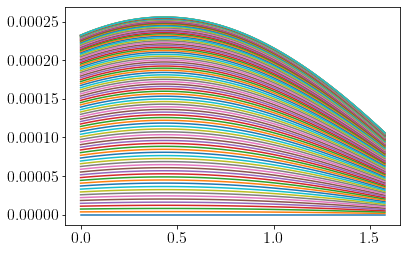

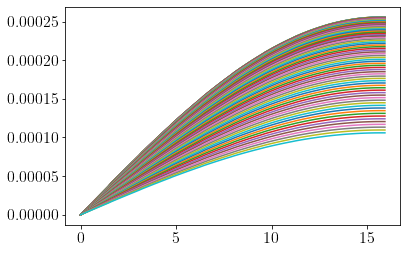

In [42]:

# ax.legend([r'$\langle X \rangle$',r'$\langle Y \rangle$',r'$\langle Z \rangle$'])
# ax.set_xlabel(r'Time $t$')
# ax.set_ylabel(r'Sensor coherence')

indc = 1

fig1, ax1 = plt.subplots()
for indtau in range(tauVals.size): 
    ax1.plot(ts,coherenceVals[indtau,indc,:])

fig2, ax2 = plt.subplots()    
for indt in range(ts.size): 
    ax2.plot(tauVals,coherenceVals[:,indc,indt])

    

Text(0, 0.5, 'Sensor coherence')

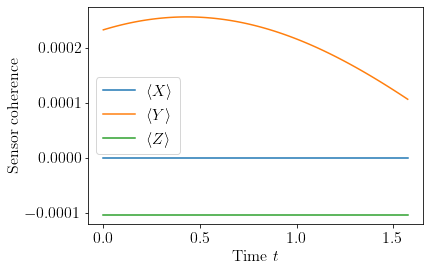

In [20]:
plt.plot(ts,rs[0,:])
plt.plot(ts,rs[1,:])
plt.plot(ts,rs[2,:])
plt.legend([r'$\langle X \rangle$',r'$\langle Y \rangle$',r'$\langle Z \rangle$'])
plt.xlabel(r'Time $t$')
plt.ylabel(r'Sensor coherence')
# plt.savefig('coherences_toy_molecule.pdf', dpi=400, bbox_inches='tight')

In [ ]:
# Changes made: 
# get_trotter_energies modified to allow different interaction anisotropies (gAB, gBB)
# build_evolution_vect modified to use new get_trotter_energies and change protocol to free molecule evolution followed by (forward) sensing
# build_rotations function created